# Demo 9: Measuring Model Performance Beyond Accuracy

A model's loss curve drops smoothly, and validation accuracy hits 99.8%. Mission accomplished? Not necessarily. The real question is whether the model actually solves the problem it was built for, and that requires the right evaluation.

> **Overview**: Discover how evaluation metrics reveal what your model is actually doing, and why 99.8% test accuracy can hide important performance details. Learn to use confusion matrices, precision, recall, and F1 score to evaluate your model on what matters.
> 
> **Scenario**: Your fraud detector shows 99.8% accuracy, and management is ready to deploy. But before going live, you need to answer critical questions that accuracy can't: How many fraud cases are we actually catching? How often are fraud alerts correct? _What metrics reveal the full picture?_
> 
> **Goal**: Learn to compute and interpret evaluation metrics that expose model behavior, especially on imbalanced datasets where accuracy masks critical tradeoffs.
> 
> **Tools**: Python, PyTorch, NumPy, scikit-learn, Matplotlib

## Step 1: Setup

Let's start by importing our libraries and setting up our environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Create output directory for visualizations
output_dir = 'assets/demo9'
os.makedirs(output_dir, exist_ok=True)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Setup complete!\n")

Using device: cuda
Setup complete!



## Step 2: Load and prepare the data

We'll use the [David-Egea/Creditcard-fraud-detection](https://huggingface.co/datasets/David-Egea/Creditcard-fraud-detection) dataset from Hugging Face, which contains credit card transactions with severe class imbalance.

For preprocessing, we'll:
1. Load the dataset 
2. Subset to 50,000 transactions
3. Explore the class imbalance
4. Split features (V1-V28, Time, Amount) from labels (Class)
4. Create train/test split (70/30) with stratification
6. Normalize features for neural network training
7. Convert to PyTorch tensors

**IMPORTANT: Feel free to skip this section to focus on the evaluation metrics**. Just know that we end up with ~35,000 training transactions and ~15,000 test transactions, where only ~0.17% are fraudulent. We'll train the model on the training set, then evaluate it on the held-out test set to demonstrate how metrics reveal model behavior.

In [2]:
# 1. Load the dataset
print("Loading credit card fraud dataset...")
dataset = load_dataset('David-Egea/Creditcard-fraud-detection', split='train')

# Convert to pandas DataFrame for easier manipulation
df = dataset.to_pandas()

# 2. Subset to 50,000 transactions for manageable demo
df = df.sample(n=50000, random_state=42).reset_index(drop=True)

print(f"✓ Dataset loaded: {len(df)} transactions")
print(f"✓ Features: {df.shape[1] - 1} (V1-V28, Time, Amount)")
print(f"✓ Target: Class (0=legitimate, 1=fraud)\n")

Loading credit card fraud dataset...
✓ Dataset loaded: 50000 transactions
✓ Features: 30 (V1-V28, Time, Amount)
✓ Target: Class (0=legitimate, 1=fraud)



> **What do the V1-V28 features represent?** The V1-V28 features are the result of PCA (Principal Component Analysis) applied by the dataset creators to protect cardholder privacy. This transformation gives us 28 anonymized features that capture the essential patterns in the original transaction data without revealing sensitive information. 
> 
> Get started with PCA by reviewing [`torch.pca_lowrank`](https://docs.pytorch.org/docs/stable/generated/torch.pca_lowrank.html?utm_source=chatgpt.com).

CLASS DISTRIBUTION
Legitimate transactions: 49,917 (99.834%)
Fraudulent transactions: 83 (0.166%)

Imbalance ratio: 601:1


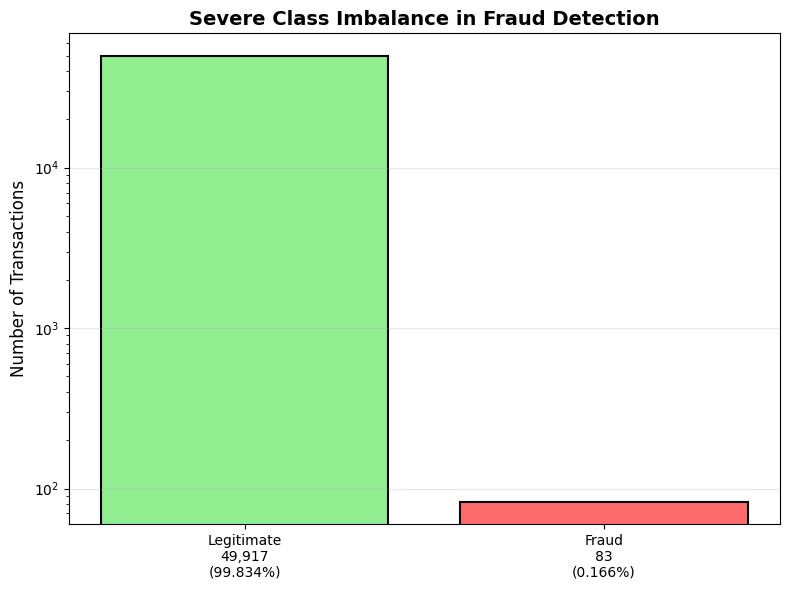

In [3]:
# 3. Explore the class imbalance
fraud_count = (df['Class'] == 1).sum()
legit_count = (df['Class'] == 0).sum()
fraud_percentage = (fraud_count / len(df)) * 100

print("="*60)
print("CLASS DISTRIBUTION")
print("="*60)
print(f"Legitimate transactions: {legit_count:,} ({100-fraud_percentage:.3f}%)")
print(f"Fraudulent transactions: {fraud_count:,} ({fraud_percentage:.3f}%)")
print(f"\nImbalance ratio: {legit_count/fraud_count:.0f}:1")
print("="*60)

# Visualize the imbalance
fig, ax = plt.subplots(figsize=(8, 6))
counts = [legit_count, fraud_count]
labels = [f'Legitimate\n{legit_count:,}\n({100-fraud_percentage:.3f}%)', 
          f'Fraud\n{fraud_count:,}\n({fraud_percentage:.3f}%)']
colors = ['#90EE90', '#FF6B6B']

ax.bar(labels, counts, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of Transactions', fontsize=12)
ax.set_title('Severe Class Imbalance in Fraud Detection', fontsize=14, fontweight='bold')
ax.set_yscale('log')  # Log scale to show both classes
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'class_imbalance.png'), dpi=300, bbox_inches='tight')
plt.show()

> **Understanding the imbalance**: With only 0.17% fraud, a naive model that predicts "legitimate" for every transaction would achieve 99.83% accuracy without detecting a single fraud case. This demonstrates why accuracy can be misleading for imbalanced datasets.

In [4]:
# 4. Split features from labels
X = df.drop('Class', axis=1).values  # All features (V1-V28, Time, Amount)
y = df['Class'].values  # Binary labels (0 or 1)

print(f"✓ Features shape: {X.shape}")
print(f"✓ Labels shape: {y.shape}")

# 5. Create train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"    ✓ Train fraud rate: {(y_train.sum()/len(y_train))*100:.3f}%")
print(f"    ✓ Test fraud rate: {(y_test.sum()/len(y_test))*100:.3f}%")

# 6. Normalize features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"✓ Features normalized (mean=0, std=1) using training set statistics")

# 7. Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

print(f"✓ Converted to PyTorch tensors")
print(f"  - X_train: {X_train_tensor.shape}")
print(f"  - X_test: {X_test_tensor.shape}")
print("\nData preparation complete!\n")

✓ Features shape: (50000, 30)
✓ Labels shape: (50000,)
    ✓ Train fraud rate: 0.166%
    ✓ Test fraud rate: 0.167%
✓ Features normalized (mean=0, std=1) using training set statistics
✓ Converted to PyTorch tensors
  - X_train: torch.Size([35000, 30])
  - X_test: torch.Size([15000, 30])

Data preparation complete!



> **Why train/test split for evaluation?** Even though our focus is on understanding evaluation metrics, we need the split for a very important reason: proper evaluation requires a held-out test set that undergoes the same preprocessing as the training set. 
> 1. Feature normalization requires fitting the scaler on training data only, then applying those statistics to test data—this prevents data leakage.
> 2. Proper evaluation requires a held-out test set, as evaluating on training data would show artificially good performance.
>
>  The split ensures we're demonstrating real-world evaluation practices.

## Step 3: Load a pre-trained model

Instead of training from scratch, we'll use a pre-trained model that has already been trained on this data. This model achieved low loss during training (**final train loss = 0.0152**) and appeared to perform well on the validation set.

> **How did we save the model?** The model weights were saved using `torch.save(model.state_dict(), f"{output_dir}/fraud_detector.pth")`
> <br>Take a moment to learn about [`torch.save()`](https://docs.pytorch.org/docs/stable/torch.html?highlight=save#torch.save) before continuing.

<details>
<summary><b>Model Architecture Details</b></summary>

The model is a simple feedforward neural network:
- **Input layer**: 30 features (V1-V28, Time, Amount)
- **Hidden layer 1**: 64 neurons with ReLU activation
- **Hidden layer 2**: 32 neurons with ReLU activation  
- **Output layer**: 1 neuron (raw logits, no activation)

It was trained using `BCEWithLogitsLoss()` loss with pos_weight to handle the severe class imbalance, and Adam optimizer for 200 epochs on the training set.

</details>

In [5]:
# 1. Define the model architecture
class FraudDetector(nn.Module):
    def __init__(self, input_size=30):
        super(FraudDetector, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Return raw logits (no sigmoid)
        return x

# 2. Create model and load pre-trained weights
model = FraudDetector(input_size=30)
model_path = os.path.join(output_dir, 'fraud_detector.pth')
model.load_state_dict(torch.load(model_path))
model.to(device)

# 3. Set model to evaluation mode
model.eval()

print("✓ Pre-trained model loaded successfully")

✓ Pre-trained model loaded successfully


> **Loading a pre-trained model**: We use [`torch.load()`](https://docs.pytorch.org/docs/stable/generated/torch.load.html) to load saved model weights from a `.pth` file, then apply them with [`model.load_state_dict()`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict). This is how you'd load any previously trained model in PyTorch. 
> 
> **What does `model.eval()` do?** The [`model.eval()`]() call switches the model to an evaluation model. This disables dropout and batch normalization updates, ensuring consistent predictions. Always call `eval()` before making predictions on test data.

## Step 4: Evaluate model performance

Now that we have the trained model, it's time to evaluate how well it performs. We'll start by getting predictions on the test set, then compute various metrics to understand the model's behavior. 

Remember: the model outputs probabilities between 0 and 1, which we'll convert to binary predictions using a threshold of 0.5.

### 4.1: Get predictions on test set

First, let's get the model's predictions on our test data. We'll extract both the raw probability outputs (useful for threshold adjustment later) and the binary predictions (fraud vs. legitimate).

In [6]:
# Get predictions from the model
with torch.no_grad():
    # Get raw logits from model
    logits = model(X_test_tensor.to(device)).squeeze()
    
    # Convert logits to probabilities using sigmoid (since we used BCEWithLogitsLoss for training)
    probabilities = torch.sigmoid(logits).cpu()
    
    # Convert probabilities to binary predictions using 0.5 threshold
    predictions = (probabilities >= 0.5).float()

### 4.2: Compute model accuracy

Let's start with the most intuitive metric: accuracy. We'll compute it manually to understand what it's actually measuring.

In [7]:
# Compute accuracy manually: (correct predictions / total predictions) × 100
correct = (predictions == y_test_tensor).sum().item()
total = len(y_test_tensor)
accuracy = (correct / total) * 100

print("="*60)
print("NAIVE ACCURACY EVALUATION")
print("="*60)
print(f"Correct predictions: {correct:,} / {total:,}")
print(f"Accuracy: {accuracy:.2f}%")
print("="*60)
print("\n✓ ~99.8% accuracy! This looks great! ...or does it?")

NAIVE ACCURACY EVALUATION
Correct predictions: 14,956 / 15,000
Accuracy: 99.71%

✓ ~99.8% accuracy! This looks great! ...or does it?


> **Why move probabilities to `.cpu()`?**: After getting predictions from the model (which may be on GPU via `.to(device)`), we move the results back to CPU with `.cpu()`. This is necessary because scikit-learn's metric functions (which we'll use next) expect NumPy arrays, and PyTorch can only convert CPU tensors to NumPy. 
> 
> It's a common pattern: compute on GPU for speed, move to CPU for compatibility with other libraries.

#### Breaking down the predictions by class

Accuracy tells us overall correctness, but in fraud detection, we care about different questions: 
- Are we catching fraud cases? 
- Are we creating too many false alarms? 

Let's break down the 99.71% accuracy by looking at what the model predicts for each class separately.

In [8]:
# Now let's reveal what's actually happening
# Count how many of each class we predicted
pred_fraud = (predictions == 1).sum().item()
pred_legit = (predictions == 0).sum().item()

# Count actual fraud cases we caught
actual_fraud_mask = (y_test_tensor == 1)
caught_fraud = (predictions[actual_fraud_mask] == 1).sum().item()
total_fraud = actual_fraud_mask.sum().item()

print("\n" + "="*60)
print("REVEALING THE HIDDEN TRADEOFFS")
print("="*60)
print("\nWhat the model actually predicted:")
print(f"  Predicted as legitimate: {pred_legit:,} ({(pred_legit/total)*100:.2f}%)")
print(f"  Predicted as fraud: {pred_fraud:,} ({(pred_fraud/total)*100:.2f}%)")
print(f"\nOut of {total_fraud} actual fraud cases:")
print(f"  Caught: {caught_fraud}")
print(f"  Missed: {total_fraud - caught_fraud}")
print(f"  Detection rate: {(caught_fraud/total_fraud)*100:.1f}%")
print("\n" + "="*60)


REVEALING THE HIDDEN TRADEOFFS

What the model actually predicted:
  Predicted as legitimate: 14,941 (99.61%)
  Predicted as fraud: 59 (0.39%)

Out of 25 actual fraud cases:
  Caught: 20
  Missed: 5
  Detection rate: 80.0%



> **What accuracy hides**: The model achieves 99.7% accuracy, which sounds great! But that single number masks important tradeoffs: it catches 80% of fraud (good recall), but also predicts 59 fraud entries of which only 20 are correct.
> 
> High accuracy on imbalanced data doesn't tell you about the precision-recall balance, i.e., the tradeoff between catching fraud and avoiding false alarms.

### 4.3: Calculate the confusion matrix

We've seen the model struggles with fraud detection, but we need more detail: 
- Exactly how many fraud cases are we missing? 
- How many false alarms are we creating? 

The confusion matrix answers both questions by breaking down all predictions into four categories.

In [9]:
# Compute confusion matrix using scikit-learn
cm = confusion_matrix(y_test_tensor.numpy(), predictions.numpy())

# Extract the four values
tn, fp, fn, tp = cm.ravel()

print("="*60)
print("CONFUSION MATRIX")
print("="*60)
print(f"\nTrue Negatives (TN):  {tn:,}  - Correctly identified legitimate")
print(f"False Positives (FP): {fp:,}  - Falsely flagged as fraud (false alarm)")
print(f"False Negatives (FN): {fn:,}  - Missed fraud cases (critical!)")
print(f"True Positives (TP):  {tp:,}  - Correctly caught fraud")
print("\n" + "="*60)

CONFUSION MATRIX

True Negatives (TN):  14,936  - Correctly identified legitimate
False Positives (FP): 39  - Falsely flagged as fraud (false alarm)
False Negatives (FN): 5  - Missed fraud cases (critical!)
True Positives (TP):  20  - Correctly caught fraud



> **Confusion matrix terminology reminder**:
> - **True Negative (TN)**: Model predicted legitimate, and it was legitimate ✓
> - **False Positive (FP)**: Model predicted fraud, but it was legitimate (false alarm)
> - **False Negative (FN)**: Model predicted legitimate, but it was fraud (missed case)
> - **True Positive (TP)**: Model predicted fraud, and it was fraud ✓
> 
> Remember: "True/False" = was the prediction correct? "Positive/Negative" = what did the model predict?

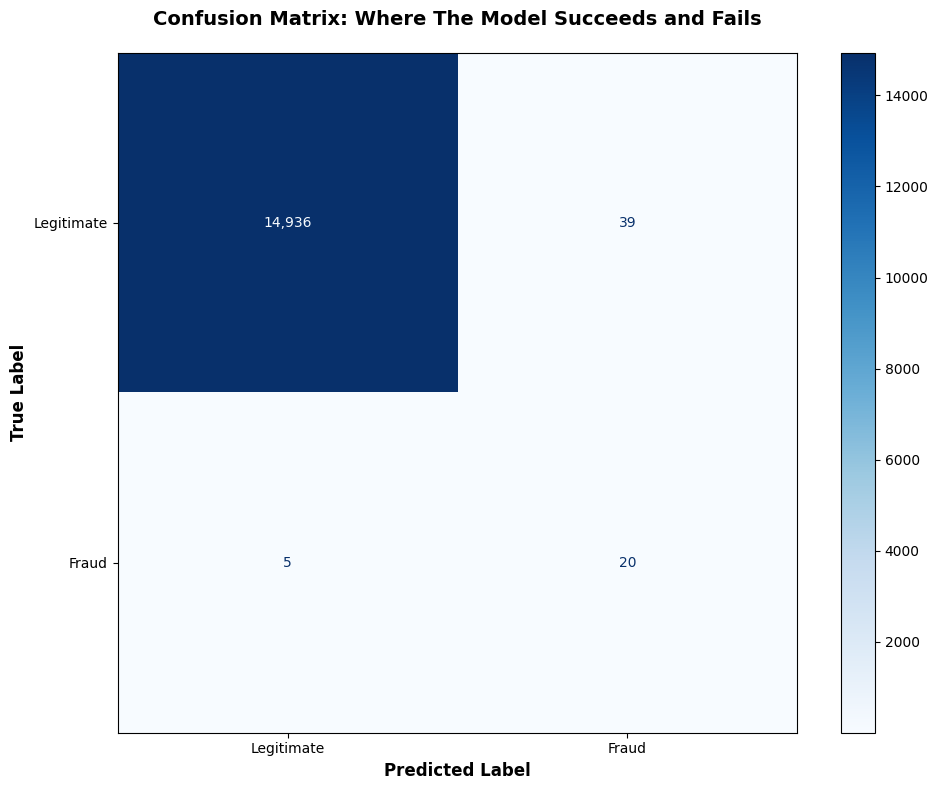

In [10]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=['Legitimate', 'Fraud'])

disp.plot(cmap='Blues', ax=ax, colorbar=True, values_format=',')

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix: Where The Model Succeeds and Fails', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

> **Reading the confusion matrix**: The large TN count (14,936) drives high accuracy, but that doesn't tell the whole story. The model catches most fraud (TP=20, FN=5) but creates false alarms (FP=39). 
> 
> These four numbers reveal what accuracy hides: the model's tradeoff between detecting fraud and avoiding false alerts.

### 4.4: Calculate precision and recall

The confusion matrix shows us the raw counts, but how do we interpret them? Precision and recall translate those four numbers into actionable insights: 
- Can we trust fraud predictions? (precision)
- Are we catching fraud? (recall)

In [11]:
# Calculate precision and recall manually to understand the formulas

# Precision: Of all fraud predictions, how many were correct?
# Formula: TP / (TP + FP)
if (tp + fp) > 0:
    precision = tp / (tp + fp)
else:
    precision = 0.0

# Recall: Of all actual fraud cases, how many did we catch?
# Formula: TP / (TP + FN)
if (tp + fn) > 0:
    recall = tp / (tp + fn)
else:
    recall = 0.0

print("="*60)
print("PRECISION AND RECALL")
print("="*60)
print(f"\nPrecision: {precision:.3f} ({precision*100:.1f}%)")
print(f"  - Interpretation: When we predict fraud, we're right {precision*100:.1f}% of the time")
print(f"  - Formula: TP / (TP + FP) = {tp} / ({tp} + {fp})")
print(f"  - Question answered: 'Can we trust positive predictions?'")

print(f"\nRecall: {recall:.3f} ({recall*100:.1f}%)")
print(f"  - Interpretation: We're catching {recall*100:.1f}% of actual fraud cases")
print(f"  - Formula: TP / (TP + FN) = {tp} / ({tp} + {fn})")
print(f"  - Question answered: 'Are we catching what matters?'")

PRECISION AND RECALL

Precision: 0.339 (33.9%)
  - Interpretation: When we predict fraud, we're right 33.9% of the time
  - Formula: TP / (TP + FP) = 20 / (20 + 39)
  - Question answered: 'Can we trust positive predictions?'

Recall: 0.800 (80.0%)
  - Interpretation: We're catching 80.0% of actual fraud cases
  - Formula: TP / (TP + FN) = 20 / (20 + 5)
  - Question answered: 'Are we catching what matters?'


> **Precision vs. recall tradeoff**: Precision measures trust ("When we flag fraud, are we right?") while recall measures coverage ("Are we catching fraud?"). 
> 
> This model has **low precision (34%)** but **good recall (80%)**. It's catching most fraud cases, but creating false alarms since only 34% of fraud predictions are correct. For fraud detection, this tradeoff often makes sense: missing fraud is costly, and false alarms can be reviewed manually. But in other domains (like spam filtering), false positives might be more problematic.

In [12]:
# Sanity check: Verify with scikit-learn (should match our manual calculation)
sk_precision = precision_score(y_test_tensor.numpy(), predictions.numpy())
sk_recall = recall_score(y_test_tensor.numpy(), predictions.numpy())

print("\nImplementation verification using scikit-learn:")
print(f"  Precision: {'✓ Matches' if sk_precision==precision else 'X Doesn\'t match'}")
print(f"  Recall: {'✓ Matches' if sk_recall==recall else 'X Doesn\'t match'}")
print("\n(Do our manual calculations match?)")


Implementation verification using scikit-learn:
  Precision: ✓ Matches
  Recall: ✓ Matches

(Do our manual calculations match?)


> **Manual calculation vs. scikit-learn**: We calculate all metrics in the demo manually to understand the formulas. 
> In practice, you'd use scikit-learn's metric functions (e.g., `precision_score()` and `recall_score()`), which handle edge cases (like division by zero) and offer options for multi-class problems.

### 4.5: Implement F1 score

Precision and recall each tell part of the story, but stakeholders often want one number. F1 score combines both using the harmonic mean, providing a single metric that balances trust and coverage.

In [13]:
# Calculate F1 score manually
# Formula: 2 × (Precision × Recall) / (Precision + Recall)

if (precision + recall) > 0:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0.0

print("="*60)
print("F1 SCORE")
print("="*60)
print(f"\nF1 Score: {f1:.3f} ({f1*100:.1f}%)")
print(f"  - Formula: 2 × (P × R) / (P + R)")
print(f"  - Formula: 2 × ({precision:.3f} × {recall:.3f}) / ({precision:.3f} + {recall:.3f})")

# Verify with scikit-learn
sk_f1 = f1_score(y_test_tensor.numpy(), predictions.numpy())
print(f"\nVerification using scikit-learn: {sk_f1:.3f} ✓")

F1 SCORE

F1 Score: 0.476 (47.6%)
  - Formula: 2 × (P × R) / (P + R)
  - Formula: 2 × (0.339 × 0.800) / (0.339 + 0.800)

Verification using scikit-learn: 0.476 ✓


> **Why harmonic mean?**: The harmonic mean (used in F1) penalizes imbalances between precision and recall. In our case, precision (34%) and recall (80%) are significantly imbalanced, giving F1 of 48% which is much closer to the lower value. 
> 
> If the gap were even more extreme (e.g., precision 90%, recall 10%), the harmonic mean would be only 18%, correctly reflecting that the model fails at one critical aspect despite excelling at another. This makes F1 more informative than a simple average when you need both metrics to be reasonably high.

## Step 5: Bring all metrics together

Let's bring all the metrics together and see how they tell different stories about the same model.

In [14]:
# Create a comprehensive metrics summary
print("\n" + "="*70)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*70)
print(f"\n{'Metric':<20} {'Value':>10} {'What it reveals':<40}")
print("-"*70)
print(f"{'Accuracy':<20} {accuracy:>9.1f}% {'Overall correctness (hides tradeoffs)':<40}")
print(f"{'Precision':<20} {precision*100:>9.1f}% {'⚠︎ Trust in fraud predictions (LOW!)':<40}")
print(f"{'Recall':<20} {recall*100:>9.1f}% {'✓ Fraud detection rate (GOOD!)':<40}")
print(f"{'F1 Score':<20} {f1*100:>9.1f}% {'Balance of precision & recall':<40}")
print("="*70)

print("\nKey insights from the confusion matrix:")
print(f"  True Negatives:  {tn:>6,}  (Correctly identified legitimate)")
print(f"  False Positives: {fp:>6,}  (False alarms - causing low precision)")
print(f"  False Negatives: {fn:>6,}  (Missed fraud - acceptable rate)")
print(f"  True Positives:  {tp:>6,}  (Correctly caught fraud)")


COMPREHENSIVE EVALUATION SUMMARY

Metric                    Value What it reveals                         
----------------------------------------------------------------------
Accuracy                  99.7% Overall correctness (hides tradeoffs)   
Precision                 33.9% ⚠︎ Trust in fraud predictions (LOW!)    
Recall                    80.0% ✓ Fraud detection rate (GOOD!)          
F1 Score                  47.6% Balance of precision & recall           

Key insights from the confusion matrix:
  True Negatives:  14,936  (Correctly identified legitimate)
  False Positives:     39  (False alarms - causing low precision)
  False Negatives:      5  (Missed fraud - acceptable rate)
  True Positives:      20  (Correctly caught fraud)


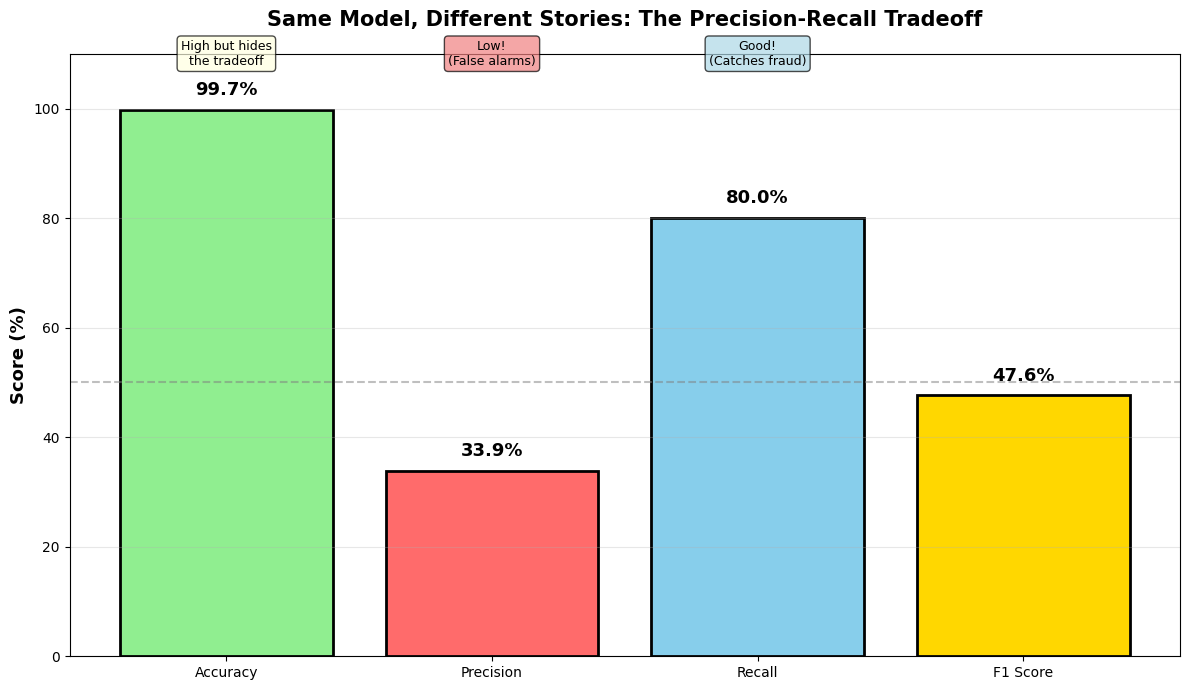


✓ Visualization reveals the precision-recall tradeoff hidden by accuracy


In [15]:
# Visualize the metric comparison
fig, ax = plt.subplots(figsize=(12, 7))

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [accuracy, precision*100, recall*100, f1*100]
colors = ['#90EE90', '#FF6B6B', '#87CEEB', '#FFD700']  # Swapped colors for precision/recall

bars = ax.bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, metrics_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{value:.1f}%', ha='center', va='bottom', fontsize=13, fontweight='bold')

ax.set_ylabel('Score (%)', fontsize=13, fontweight='bold')
ax.set_title('Same Model, Different Stories: The Precision-Recall Tradeoff', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_ylim(0, 110)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
ax.grid(axis='y', alpha=0.3)

# Add interpretation boxes
ax.text(0, 108, 'High but hides\nthe tradeoff', ha='center', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
ax.text(1, 108, 'Low!\n(False alarms)', ha='center', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
ax.text(2, 108, 'Good!\n(Catches fraud)', ha='center', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'metrics_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization reveals the precision-recall tradeoff hidden by accuracy")

> **The power of multiple metrics**: Accuracy alone (99.8%) suggested good performance, but precision and recall revealed the tradeoff: the model catches most fraud (76% recall) but creates false alarms (45% precision). 
> 
> This is why production systems always track multiple metrics: each one answers a different question about model behavior.

## Conclusion

Congratulations! You've just learned how to properly evaluate a classification model beyond surface-level metrics.

**What you've learned:**

- [x] **The accuracy trap** - Why 99.7% accuracy can hide important model behavior on imbalanced data
- [x] **Confusion matrix power** - The 2×2 grid that reveals exactly where your model succeeds and fails
- [x] **Precision vs. recall** - Two metrics answering different questions (trust vs. coverage)
- [x] **F1 score** - Combining precision and recall into a balanced summary metric
- [x] **The precision-recall tradeoff** - Understanding why catching more fraud means more false alarms
- [x] **PyTorch + scikit-learn** - Using both libraries together for complete evaluation

> **Critical insight**: Loss guides training, but evaluation metrics tell you if the model solves the actual problem. For imbalanced datasets, accuracy often hides important tradeoffs. So, always examine the confusion matrix and compute precision/recall to understand what your model is really doing. The "best" metric depends entirely on your problem: fraud detection may prioritize recall (catch fraud!), spam filters may prioritize precision (avoid false alarms), and different stakeholders care about different aspects of performance.

##### Next steps to explore:

- [ ] **How do you find the optimal threshold?** Our model uses 0.5 by default, giving 80% recall and 34% precision. But what if you want 90% recall? Or 80% precision? Is there a systematic way to visualize all possible thresholds at once and choose the optimal operating point for your business constraints?

- [ ] **How do you compare models fairly?** If Model A has 70% precision and 80% recall, while Model B has 80% precision and 70% recall, which is better? You need a threshold-independent metric that captures overall model quality, not just performance at one operating point.

- [ ] **What if class imbalance is even worse?** With 0.17% fraud, accuracy was misleading but precision/recall worked. But what about problems with 0.01% or 0.001% positive class? Do you need different metrics or different evaluation strategies?

- [ ] **How do you encode business costs into evaluation?** In fraud detection, missing a \$10,000 fraud case is worse than a false alarm that costs \$5 to review. Can you create custom metrics that weight errors by their real-world impact rather than treating all mistakes equally?